# Import

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from torchvision import transforms
import numpy as np

from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import glob
from PIL import Image

import os
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import random


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

from utils import linear_schedule,sigmoid_beta_schedule, add_noise, denoise_step, sample_plot_image, show_tensor_image
from diffusion_model import Unet

ModuleNotFoundError: No module named 'utils'

# Generate Image

In [ ]:
IMG_SIZE = 64
BATCH_SIZE = 10
img_size = IMG_SIZE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 1000  # Total number of timesteps
# Precompute terms for the diffusion process
betas = sigmoid_beta_schedule(T).to(device)  # [T]
alphas = 1.0 - betas  # [T]
alphas_cumprod = torch.cumprod(alphas, dim=0)  # [T]

In [ ]:
model_dog = Unet()
model_dog.load_state_dict(torch.load('./model_OxfordPet_dog_v4.pth'))

device = torch.device("cuda")
model_dog.to(device)

In [ ]:
def generate_image(model, T):
  device = torch.device("cuda")
  model.to(device)

  img = torch.randn((1, 3, 64, 64), device=device)  # [1, 3, img_size, img_size]
  # num_images = 10
  # stepsize = T // num_images
  with torch.no_grad():
    for i in reversed(range(T)):
          #print(i)
          t = torch.full((1,), i, device=device, dtype=torch.long)  # [1]
          img = denoise_step(img, t, model)  # [1, 3, img_size, img_size]
          img = torch.clamp(img, -1.0, 1.0)  # Clamp to maintain [-1, 1] range
  return img

In [ ]:
import os
directory = 'synthetic_dataset_dog'
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
def generate_synthetic_dataset(model, num_images,directory):
  reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

  if not os.path.exists(directory):
      os.makedirs(directory)

  device = torch.device("cuda")
  model.to(device)

  for i in range(num_images):
    img = generate_image(model_dog, 1000)
    img = img.squeeze(0)
    img = img.detach().cpu()
    img = reverse_transforms(img)
    img.save(f'./{directory}/{i}.png')
    #plt.imshow(img)

In [ ]:
#generate_synthetic_dataset(model_dog,100,'synthetic_dataset_dog')

In [ ]:
# !zip -r synthetic_dataset_dog.zip synthetic_dataset_dog/

In [ ]:
#!unzip synthetic_dataset_dog.zip

# Data Processing/Augmentation

In [ ]:


class CombinedOxfordPetCustomDataset(Dataset):
    def __init__(self, oxford_pet_data, custom_folder_path=None, transform=None):
        """
        Initializes the dataset.
        :param oxford_pet_data: Preprocessed Oxford Pet dataset with images and labels.
        :param custom_folder_path: Optional path to the folder containing additional images.
        :param transform: Transformations to apply to the images.
        """
        # Filter and relabel Oxford Pet data
        label_map = {2: 1, 3: 1, 4: 1, 15: 1, 5: 0, 6: 0, 7: 0, 9: 0}
        filtered_data = [(img, label_map[label]) for img, label in oxford_pet_data if label in label_map]
        self.pet_data, self.pet_labels = zip(*filtered_data) if filtered_data else ([], [])

        self.custom_images = []
        self.custom_labels = []

        # Load custom data from folder
        if custom_folder_path:
            for image_path in glob.glob(os.path.join(custom_folder_path, '*.png')):
                image = Image.open(image_path).convert('RGB')
                if transform:
                    image = transform(image)
                self.custom_images.append(image)
                self.custom_labels.append(1)

        self.transform = transform

    def __len__(self):
        return len(self.pet_data) + len(self.custom_images)

    def __getitem__(self, index):
        if index < len(self.pet_data):
            data = self.pet_data[index]
            label = self.pet_labels[index]
        else:
            custom_index = index - len(self.pet_data)
            data = self.custom_images[custom_index]
            label = self.custom_labels[custom_index]

        if self.transform and not isinstance(data, torch.Tensor):
            data = self.transform(data)

        return data, label


class AugmentedDataset(Dataset):
    def __init__(self, dataset, transform=None, augmentations=None, num_augmented_copies=1):
        self.dataset = dataset
        self.transform = transform
        self.augmentations = augmentations
        self.num_augmented_copies = num_augmented_copies

    def __len__(self):
        return len(self.dataset) * (1 + self.num_augmented_copies)

    def __getitem__(self, idx):
        original_idx = idx % len(self.dataset)
        is_augmented = idx // len(self.dataset) > 0

        image, label = self.dataset[original_idx]

        if self.transform:
            image = self.transform(image)

        if is_augmented and self.augmentations:
            image = self.augmentations(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img_size= 64
augmentations = transforms.Compose([

    transforms.Resize(img_size + int(.25*img_size)),  # img_size + 1/4 *img_size
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),

    ])

train_dataset = datasets.OxfordIIITPet(root='./data', split='trainval', download=True)
val_dataset = datasets.OxfordIIITPet(root='./data', split='test', download=True)


custom_folder_path = './synthetic_dataset_dog'

train_original_dataset = CombinedOxfordPetCustomDataset(train_dataset, transform=transform)
val_original_dataset = CombinedOxfordPetCustomDataset(val_dataset, transform=transform)

combined_dataset = CombinedOxfordPetCustomDataset(train_dataset, custom_folder_path, transform=transform)

# make copies of data with augmentation
augmented_train_dataset = AugmentedDataset(train_original_dataset, augmentations=augmentations, num_augmented_copies=5)
augmented_syn_dataset = AugmentedDataset(combined_dataset, augmentations=augmentations, num_augmented_copies=5)

train_loader = DataLoader(augmented_train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_original_dataset, batch_size=64)
synthetic_data_loader = DataLoader(augmented_syn_dataset, batch_size=64, shuffle=True)


In [ ]:
def check_labels(synthetic_data_loader):
    labels_list = []
    for _, labels in synthetic_data_loader:
        labels_list.extend(labels.numpy())
    return labels_list

train_labels = check_labels(train_loader)
test_labels = check_labels(val_loader)
synthetic_labels = check_labels(synthetic_data_loader)


# Print out the unique labels in the train and test subsets to verify
print("Unique labels in train subset:", np.unique(train_labels))
print("Unique labels in test subset:", np.unique(test_labels))
print("Unique labels in synthetic_data_loader subset:", np.unique(synthetic_labels))



Unique labels in train subset: [0 1]
Unique labels in test subset: [0 1]
Unique labels in synthetic_data_loader subset: [0 1]


In [ ]:
print(len(augmented_train_dataset))
print(len(augmented_syn_dataset))

4776
5376


# CNN Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding = 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32,32,kernel_size=3,padding = 1)
        self.relu2 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.conv4 = nn.Conv2d(32,64,kernel_size=3,padding = 1)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(64,64,kernel_size=3,padding = 1)
        self.relu5 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(2,stride=2)



        self.fc7 = nn.Linear(256*64,128)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(128,1)
        self.sigmoid8 = nn.Sigmoid()

    def forward(self, x):
        h = self.conv1(x)
        h = self.relu1(h)

        h = self.pool3(self.relu2(self.conv2(h)))
        h = self.relu4(self.conv4(h))
        h = self.pool6(self.relu5(self.conv5(h)))

        h = h.view(h.size(0),-1)

        h = self.relu7(self.fc7(h))
        h = self.fc8(h)

        y = self.sigmoid8(h)
        return y

KeyboardInterrupt: 

# Train and Evaluation

Epoch 1/10, Train Risk: 0.5585, Test Risk: 0.5789, Test Accuracy: 0.6992
Epoch 2/10, Train Risk: 0.4532, Test Risk: 0.5417, Test Accuracy: 0.7424
Epoch 3/10, Train Risk: 0.3978, Test Risk: 0.5271, Test Accuracy: 0.7437
Epoch 4/10, Train Risk: 0.3597, Test Risk: 0.4956, Test Accuracy: 0.7614
Epoch 5/10, Train Risk: 0.3211, Test Risk: 0.6433, Test Accuracy: 0.7652
Epoch 6/10, Train Risk: 0.2622, Test Risk: 0.5265, Test Accuracy: 0.7970
Epoch 7/10, Train Risk: 0.2340, Test Risk: 0.6005, Test Accuracy: 0.7868
Epoch 8/10, Train Risk: 0.1813, Test Risk: 0.6212, Test Accuracy: 0.7919
Epoch 9/10, Train Risk: 0.1700, Test Risk: 0.7071, Test Accuracy: 0.7754
Epoch 10/10, Train Risk: 0.1479, Test Risk: 0.7020, Test Accuracy: 0.7944


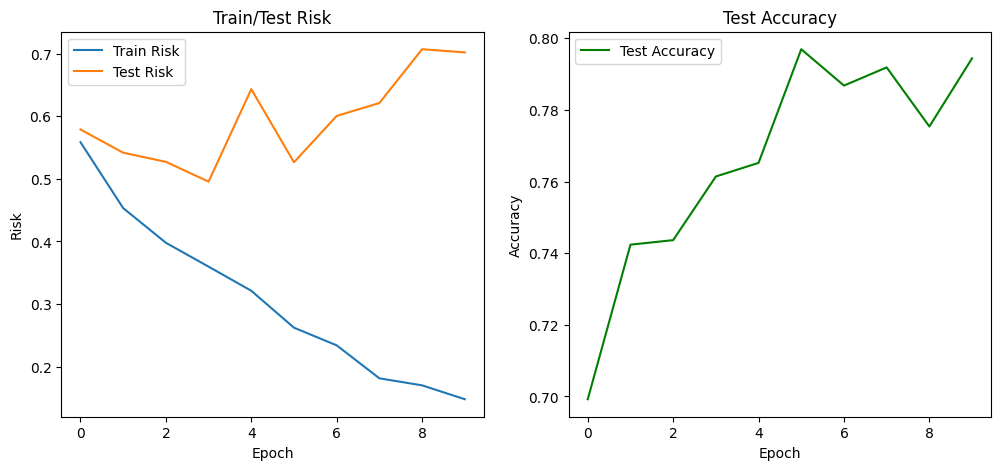

Epoch 1/10, Train Risk: 0.5911, Test Risk: 0.5500, Test Accuracy: 0.7119
Epoch 2/10, Train Risk: 0.5003, Test Risk: 0.5580, Test Accuracy: 0.7030
Epoch 3/10, Train Risk: 0.4208, Test Risk: 0.5535, Test Accuracy: 0.7449
Epoch 4/10, Train Risk: 0.3535, Test Risk: 0.6179, Test Accuracy: 0.7602
Epoch 5/10, Train Risk: 0.2795, Test Risk: 0.7597, Test Accuracy: 0.7703
Epoch 6/10, Train Risk: 0.1922, Test Risk: 0.8968, Test Accuracy: 0.7563
Epoch 7/10, Train Risk: 0.1540, Test Risk: 1.2329, Test Accuracy: 0.7297
Epoch 8/10, Train Risk: 0.0981, Test Risk: 1.0277, Test Accuracy: 0.7602
Epoch 9/10, Train Risk: 0.0885, Test Risk: 1.5896, Test Accuracy: 0.7525
Epoch 10/10, Train Risk: 0.0899, Test Risk: 1.1439, Test Accuracy: 0.7360


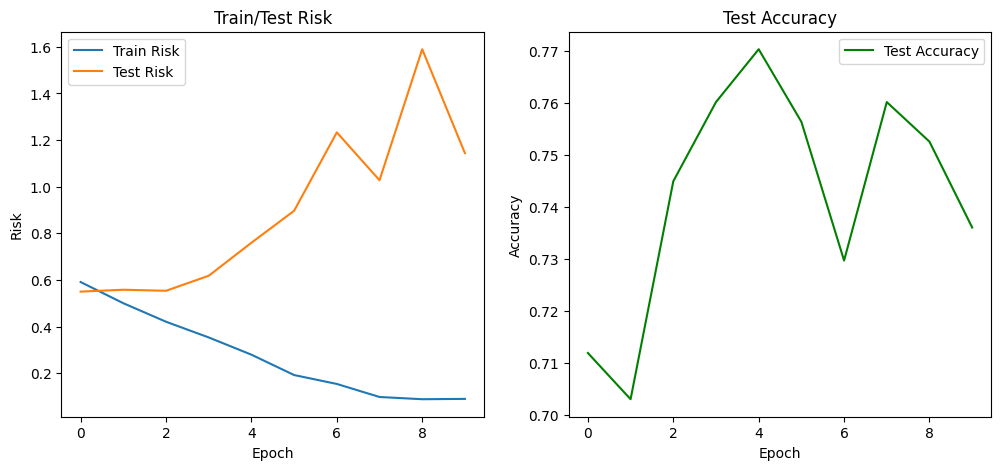

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

class Trainer:
    def __init__(self, model, train_loader, test_loader):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        random.seed(1508)
        np.random.seed(1508)
        torch.manual_seed(1508)
        torch.cuda.manual_seed_all(1508)

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device).float().view(-1, 1)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        return running_loss / len(self.train_loader.dataset)

    def evaluate(self):
        self.model.eval()
        running_loss = 0.0
        predictions = []
        true_labels = []
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device).float().view(-1, 1)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                predicted_labels = outputs.round().cpu().numpy()
                predictions.extend(predicted_labels)
                true_labels.extend(labels.cpu().numpy())
        accuracy = accuracy_score(true_labels, predictions)
        return running_loss / len(self.test_loader.dataset), accuracy

    def train(self, num_epochs):
        train_risks = []
        test_risks = []
        test_accuracies = []

        for epoch in range(num_epochs):
            train_risk = self.train_epoch()
              , test_accuracy = self.evaluate()

            train_risks.append(train_risk)
            test_risks.append(test_risk)
            test_accuracies.append(test_accuracy)

            print(f'Epoch {epoch+1}/{num_epochs}, Train Risk: {train_risk:.4f}, Test Risk: {test_risk:.4f}, Test Accuracy: {test_accuracy:.4f}')

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(train_risks, label='Train Risk')
        plt.plot(test_risks, label='Test Risk')
        plt.title('Train/Test Risk')
        plt.xlabel('Epoch')
        plt.ylabel('Risk')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(test_accuracies, label='Test Accuracy', color='green')
        plt.title('Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

trainer = Trainer(model=CNN(), train_loader=synthetic_data_loader, test_loader=val_loader)
trainer.train(num_epochs=10)

trainer = Trainer(model=CNN(), train_loader=train_loader, test_loader=val_loader)
trainer.train(num_epochs=10)
